(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Load project package
@load_pkg BayesFitness

import Revise
import Suppressor
# Import project package
import BayesFitness
# Import library to list files
import Glob

# Import package to handle DataFrames
import DataFrames as DF
import CSV
import XLSX

# Import basic statistical functions
import StatsBase
import Random
import Distributions

# Import basic math
import LinearAlgebra

# Import libraries relevant for MCMC
import Zygote
import Turing
import MCMCChains
import DynamicHMC

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
import Makie
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
BayesFitness.viz.pboc_makie!()

# Bayesian inference of barcode frequencies

`[explanation here]`

First, let's load the data.

In [2]:
# Load data
df = CSV.read("$(git_root())/data/big_batch/tidy_counts.csv", DF.DataFrame)

first(df, 5)

Row,BCID_x,bc_merged,barcode,barcode_lowcomplexity,barcode_highcomplexity,BCID_y,barcode_fasta,source_publication,cloneID,cloneID_new,evolution_condition,ancestor,class,ploidy,ploidy_new,gene,type,additional_muts,1D_Fitness_Li2019,1D_Error_Li2019,2D_Fitness_Li2019,2D_Error_Li2019,3D_Fitness_Li2019,3D_Error_Li2019,5D_Fitness_Li2019,5D_Error_Li2019,FerPerHour_Li2019,ResPerHour_Li2019,StaPerHour_Li2019,name,count,rep,timepoint,time,batch,hub,perturbation,neutral
,Int64,String,String,String31,String,Int64,String,String15,String31,String?,String7,String15,String31,String15,String15,String31,String?,String?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,String,Int64,String3,String3,Int64,String7,String7,String15,Bool
1,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,TGATCAATCTACAAAAATATTTAATG_GAGTGAAACATGAATGGTATTCATCA,TGATCAATCTACAAAAATATTTAATG,GAGTGAAACATGAATGGTATTCATCA,0,GAGTGAAACATGAATGGTATTCATCATGATCAATCTACAAAAATATTTAATG,This_study,missing,EVO2D_IRA1_MIS_rearray_Plate1-A1,Evo2D,IRA1_MIS,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,53,R1,T0,0,Batch1,1Day,28,false
2,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,CCGCCAATCCCGAACCCCGTTTCGCC_ACTCTAACGTGTAACTAATTTTGAGT,CCGCCAATCCCGAACCCCGTTTCGCC,ACTCTAACGTGTAACTAATTTTGAGT,1,ACTCTAACGTGTAACTAATTTTGAGTCCGCCAATCCCGAACCCCGTTTCGCC,Aggeli2020,gpb2_evo1_plate9_H8,gpb2_evo1_plate9_H8,Evo2D,GPB2,adaptive_haploids,Haploid,Haploid,missing,Other,DOP1-NON_SYNONYMOUS_CODING; SMD2-NON_SYNONYMOUS_CODING; YDL180W-DOWNSTREAM; LAS21-UPSTREAM,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,1213,R1,T0,0,Batch1,1Day,28,false
3,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,GACAGAAAAGCCAAATGGATTTACCG_ATGGGAACACGGAATGATCTTTTATT,GACAGAAAAGCCAAATGGATTTACCG,ATGGGAACACGGAATGATCTTTTATT,2,ATGGGAACACGGAATGATCTTTTATTGACAGAAAAGCCAAATGGATTTACCG,This_study,missing,EVO3D_TCG_rearray_Plate1-A4,Evo3D,CYR1,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,17,R1,T0,0,Batch1,1Day,28,false
4,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,CCAACAAAACACAAATCTGTTGTGTA_TACTAAATAAGTAAGGGAATTCTGTT,CCAACAAAACACAAATCTGTTGTGTA,TACTAAATAAGTAAGGGAATTCTGTT,3,TACTAAATAAGTAAGGGAATTCTGTTCCAACAAAACACAAATCTGTTGTGTA,This_study,missing,EVO2D_IRA1_NON_rearray_Plate1-A1,Evo2D,IRA1_NON,missing,missing,diploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,19,R1,T0,0,Batch1,1Day,28,false
5,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,TATCGAAACCCAAAGAGATTTAATCG_ATGACAAACTTTAAATAATTTAATTG,TATCGAAACCCAAAGAGATTTAATCG,ATGACAAACTTTAAATAATTTAATTG,4,ATGACAAACTTTAAATAATTTAATTGTATCGAAACCCAAAGAGATTTAATCG,This_study,missing,EVO3D_IRA1_MIS_rearray_Plate1-C4,Evo3D,IRA1_MIS,missing,missing,haploid,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing,Batch1_1Day-T0_combined,23,R1,T0,0,Batch1,1Day,28,false


## Bayesian model using `Turing.jl`

Let's define the basic probabilistic model with `Turing.jl`.

In [3]:
Turing.@model function multinomial_dirichlet(r̲ₜ, Rₜ, σₜ)

    ## Prior
    # Prior on Dirichlet parameters
    α̲ₜ ~ Turing.filldist(
        Turing.truncated(Turing.Normal(0, σₜ); lower=0.0), length(r̲ₜ)
    )

    ## Likelihood

    # Dirichlet likelihood for frequencies
    f̲ₜ ~ Turing.Dirichlet(α̲ₜ)

    # Multinomial likelihood for frequencies
    return r̲ₜ ~ Turing.Multinomial(Rₜ, f̲ₜ)

end # Turing.@model

multinomial_dirichlet (generic function with 2 methods)

Let's test the model with some very basic synthetic data.

In [34]:
Random.seed!(42)

# Define synthetic data (from Betancourt's tutorial on Ordinal regression)
data = [2, 4, 13, 22, 9]

# Define model
model = multinomial_dirichlet(data, sum(data), 1.0)

# Sample
chain = Turing.sample(
    model, 
    Turing.NUTS(0.65), 
    2_000, 
    progress=false
)

# Print summary stats
Turing.summarystats(chain)

┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /Users/mrazo/.julia/packages/Turing/b6CoW/src/inference/hmc.jl:190


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

       α̲ₜ[1]    0.6986    0.4218     0.0094    0.0076   2933.6341    1.0008    ⋯
       α̲ₜ[2]    0.7835    0.4711     0.0105    0.0105   2554.4420    1.0000    ⋯
       α̲ₜ[3]    1.0918    0.5831     0.0130    0.0126   2407.1114    0.9998    ⋯
       α̲ₜ[4]    1.2314    0.6224     0.0139    0.0126   2117.0716    1.0012    ⋯
       α̲ₜ[5]    0.9801    0.5417     0.0121    0.0105   2167.0268    0.9996    ⋯
       f̲ₜ[1]    0.0489    0.0300     0.0007    0.0007   3049.5528    1.0004    ⋯
       f̲ₜ[2]    0.0878    0.0418     0.0009    0.0008   3401.6766    0.9995    ⋯
       f̲ₜ[3]    0.2584    0.0603     0.0013    0.0011   2846.8479    0.9995    ⋯
       f̲ₜ[4]    0.4237    0.0666     0.0015    0.0012   3159.8286    0.9999    ⋯
       f̲ₜ[5]    0.1811    0.0528     0.0012    0.0012   2561.9794    0.9995    

Let's take a look at the traces

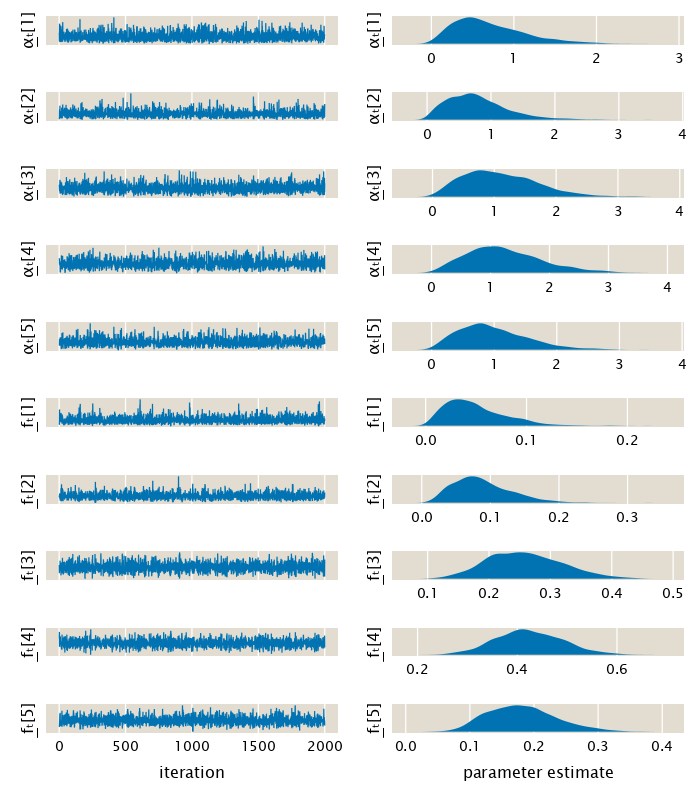

In [37]:
# Extract parameters
params = names(chain, :parameters)

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of parameters
n_samples = length(chain)

# Initialize figure
fig = Figure(resolution=(700, 800))

BayesFitness.viz.mcmc_trace_density!(fig, chain)

fig

Let's perform a simple posterior predictive check by generating samples from our
chains. 

In [105]:
# Define quantiles to compute from data
quants = [0.995, 0.95, 0.5]

# Extract number of chains
n_chains = length(MCMCChains.chains(chain))
# Extract number of samples
n_samples = length(chain)
# Extract freequency chains
freq_chains = MCMCChains.get_params(chain)[Symbol("f̲ₜ")]
# Extract frequencies into a matrix
freq_samples = hcat([x.data for x in freq_chains]...)
# Define number of parameters
n_param = size(freq_samples, 2)

# Initialize arrays to save posteerior predictive samples
r_ppc = Array{Int64}(undef, n_samples, n_param)

# Loop through samples
for i = 1:n_samples
    # Sample and store a multinomial
    r_ppc[i, :] = Random.rand(
        Distributions.Multinomial(sum(data), freq_samples[i, :])
    )
end # for

# Initialize array to save quantiles
r_ppc_quant = Array{Float64}(undef, length(quants), 2, n_param)

# Loop through quantiles
for (i, q) in enumerate(quants)
    # Compute upper and lower quantile
    r_ppc_quant[i, :, :] = hcat(
        [
                StatsBase.quantile(x, [(1. - q) / 2., 1. - (1. - q) / 2.])
                for x in eachcol(r_ppc)
        ]...
    )
end # for

Let's now plot the posterior predictive checks.

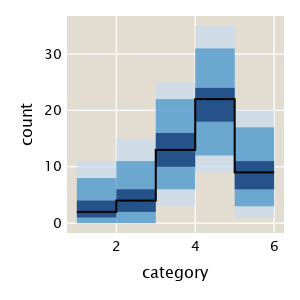

In [134]:
# Inititialize figure
fig = Figure(resolution=(300, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="category",
    ylabel="count",
)

# Define colors
colors = get(ColorSchemes.Blues_9, LinRange(0.25, 1, length(quants)))

# Loop through quants
for i = 1:size(r_ppc_quant, 1)
    # Loop through positions
    for j = 1:size(r_ppc_quant, 3)
        # Add band
        band!(
            [j, j+1], 
            repeat([r_ppc_quant[i, 1, j]], 2),
            repeat([r_ppc_quant[i, 2, j]], 2),
            color=(colors[i], 0.7)
        )
    end # for
end # for

# Plot original data
stairs!(ax,  [data; data[end]], step=:post, color=:black, linewidth=2)

fig

With this little information ($n=1$) the uncertainty on the parameters is
relatively large.

In [ ]:
# Define information for data to extract
batch = "Batch1"
hub = "1Day"
perturbation = "28"
rep = "R1"
timepoint = "T0"


# Extract data. Note: The time T0 is common to all perturbations, thus, it must
# be extracted separately as a second condition.
data = df[
        (df.hub .== hub) .& 
        (df.batch .== batch) .&
        (df.perturbation .== perturbation) .&
        (df.rep .== rep) .&
        (df.timepoint .== timepoint)
    ,
:]

first(data[:, [:timepoint, :count]], 5)

In [ ]:
Random.seed!(42)

# Switch Automatic differentiation backend
Turing.setadbackend(:zygote)

idx = size(data, 1)

# Define model
model = multinomial_dirichlet(data.count[1:idx], sum(data.count[1:idx]), 10.0)

# Sample
chain = Turing.sample(
    model, 
    # Turing.NUTS(0.65), 
    Turing.IS(),
    # Turing.HMCDA(0.15, 0.65),
    # Turing.DynamicNUTS(), 
    Turing.MCMCThreads(), 
    4_000,
    4, 
    progress=false
)

# Print summary stats
Turing.summarystats(chain)